### Objective : To predict the housing prices in Australia using advanced regression

In [612]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [613]:
#Import dataset
data=pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data Inspection


In [558]:
data.shape

(1460, 81)

1460 records with 81 columns present in data

In [559]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [560]:
#Converting relevant datatypes
data[['MSSubClass']]=data[['MSSubClass']].astype('object')

In [561]:
#Understand type of variables in data
data.dtypes.value_counts()

object     44
int64      34
float64     3
dtype: int64

43 text features and 38 numeric features

In [562]:
#Missing value ratio
#Removing columns having more than 75% missing values in entries
perc=data.isna().sum()/len(data)
cols_to_del = [col for col,val in perc.items() if val>0.75]
print("Columns removed",cols_to_del)

Columns removed ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [563]:
#Remove ID column since it has unique values and not useful for prediction
cols_to_del.append("Id")
data.drop(columns=cols_to_del,inplace=True)
data.shape

(1460, 76)

In [564]:
#Remove duplicate records if present
dup_rows=data.duplicated().sum()
print("Duplicate records present in data are:",dup_rows)

Duplicate records present in data are: 0


In [565]:
#Removing columns with low variation in data
#Check categorical data
data_cat=data.select_dtypes(include=['object'])
cat_cols=list(data_cat.columns)
#Identify columns which have more than 90% of same category value
data_cols_var=[]
for cat in cat_cols:
    val_cnt=pd.DataFrame(data_cat[cat].value_counts(normalize=True))
    if float(val_cnt.max())>=0.9:
        data_cols_var.append(cat)
del_len=len(data_cols_var)
print(f"{del_len} Categorical Columns with more than 90% of single category : {data_cols_var}")

13 Categorical Columns with more than 90% of single category : ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive']


In [566]:
#Remove low variation columns since they are not useful for prediction
data.drop(columns=data_cols_var,inplace=True)
data.shape

(1460, 63)

<AxesSubplot:xlabel='SalePrice'>

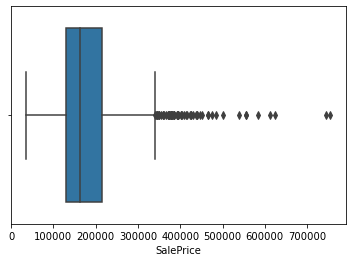

In [567]:
#Removing outliers - Target Variable
sns.boxplot(data["SalePrice"])
plt.show()

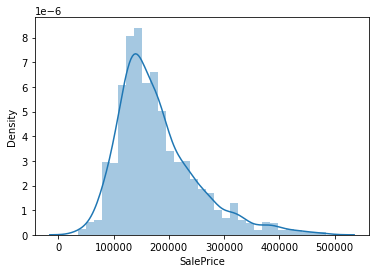

In [568]:
#We observe some outliers in the target Variable, we remove the extreme points above 500000 price
data=data[data["SalePrice"]<500000]
#Observing Distribution of sale price
sns.distplot(data["SalePrice"])
plt.show()

In [569]:
#Impute Missing Values
missing=data.isna().sum()
cols_missing_data = [col for col,val in missing.items() if val>0]
cat_missing_cols=list(data[cols_missing_data].select_dtypes(include=['object']).columns)
num_missing_cols=list(data[cols_missing_data].select_dtypes(include=['int64','float64']).columns)

In [570]:
#Impute using mode for categorical and median for numeric variables
for col in list(data.columns):
    if col in cat_missing_cols:
        mod=data[col].mode()
        data[col].fillna(mod,inplace=True)
    if col in num_missing_cols:
        med=data[col].median()
        data[col].fillna(med,inplace=True)

In [615]:
print("Shape of data after data cleaning",data.shape)

Shape of data after data cleaning (1460, 81)


There are still 63 features, and its important to select the relevant features correlating with the target variable

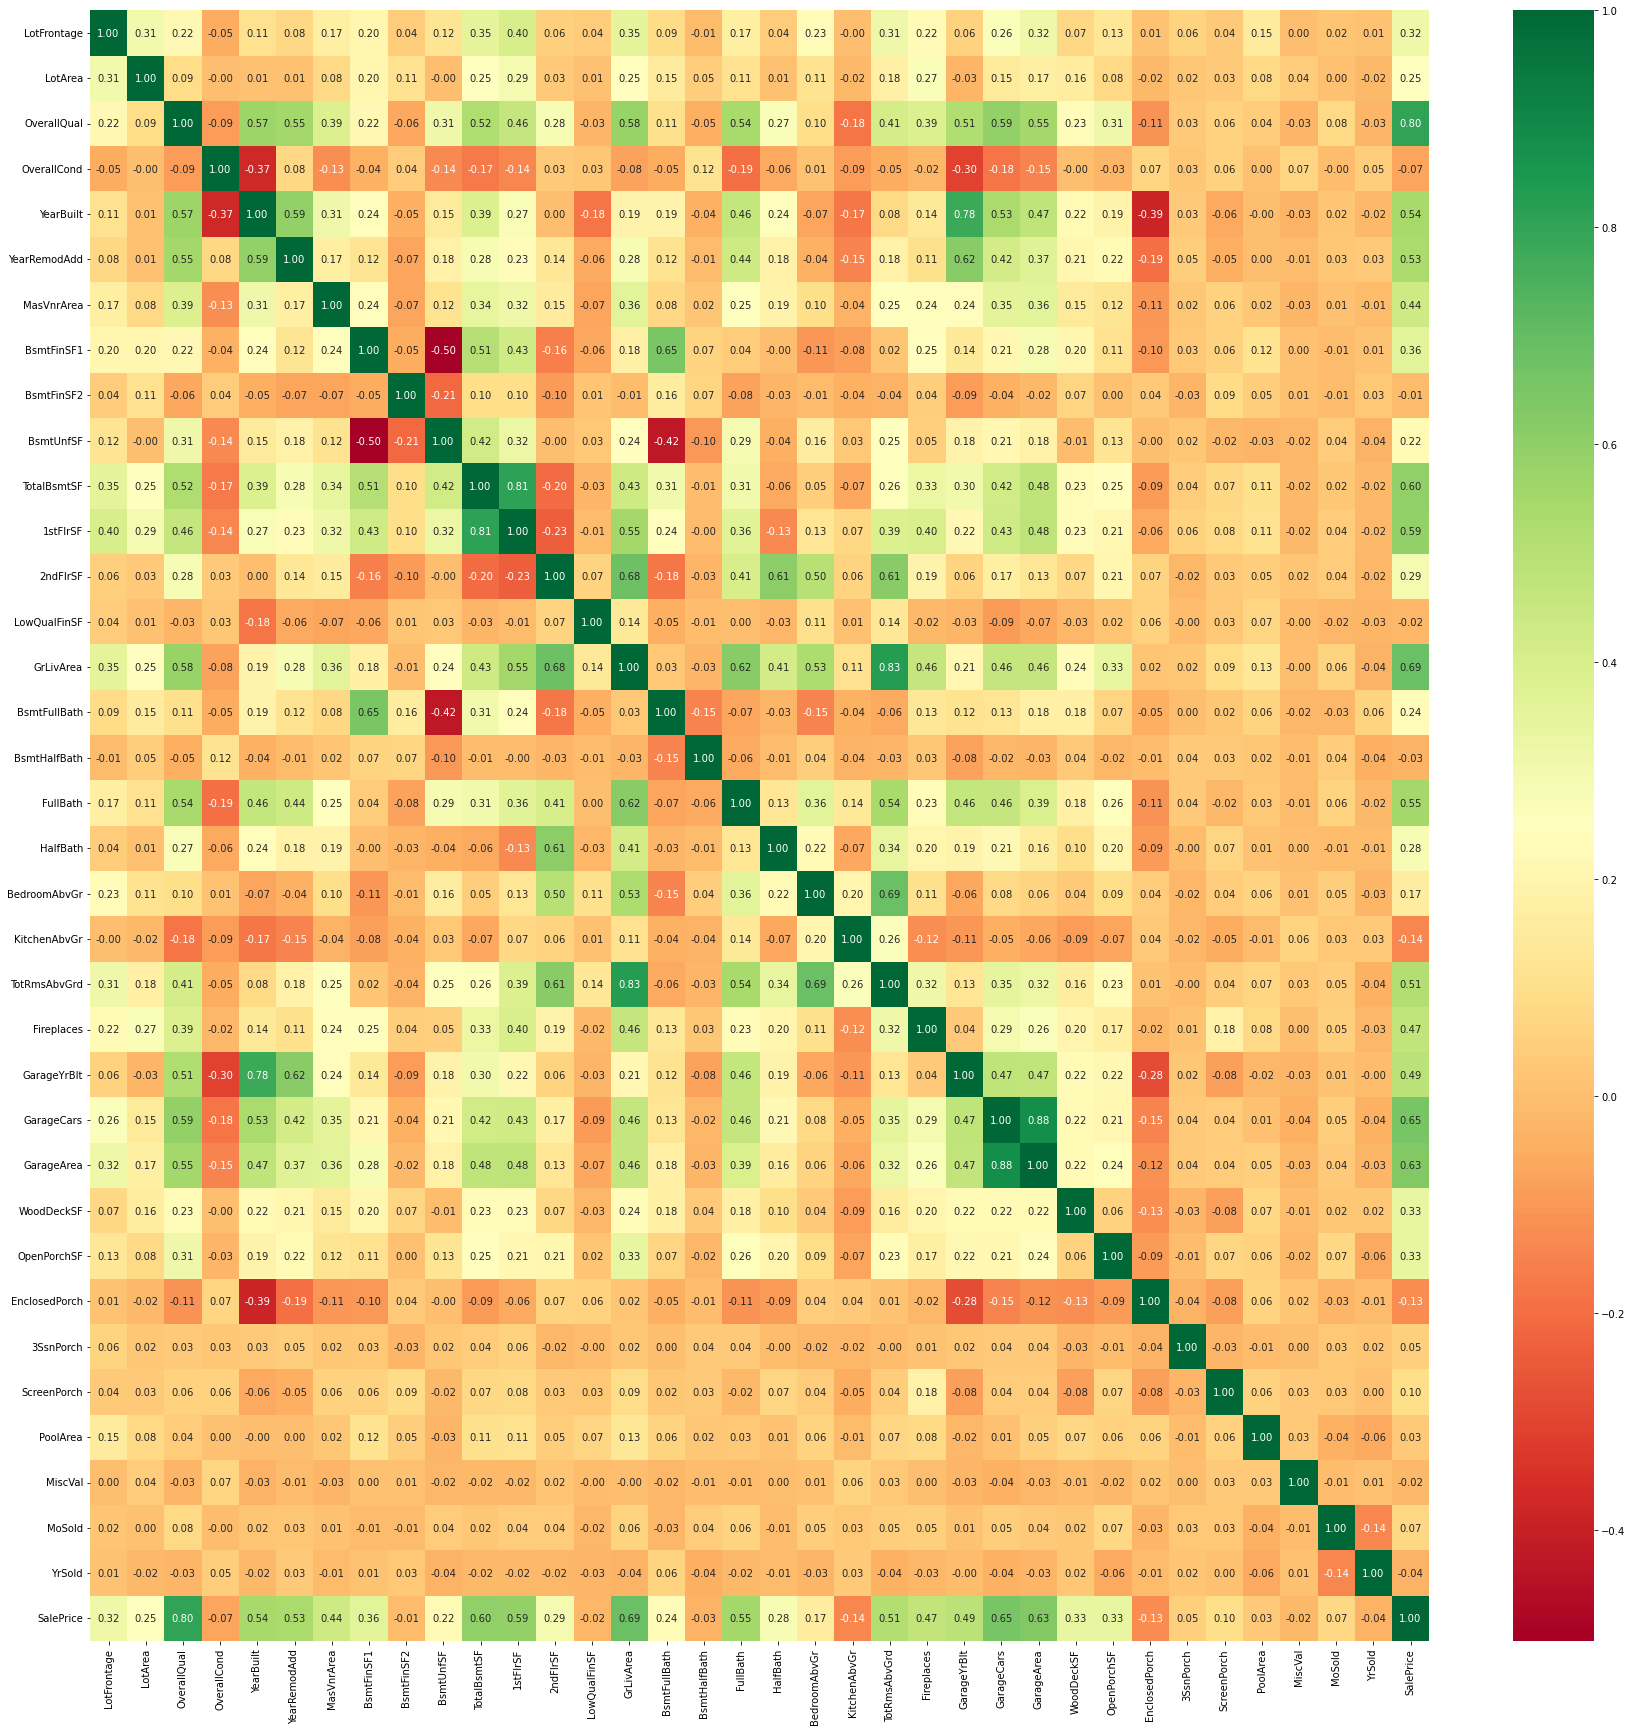

In [572]:
#Checking correlation of numeric variables with target variable(SalePrice)
num_cols=list(data.select_dtypes(include=['int64','float64']).columns)
plt.figure(figsize=(30,30))
corr_mat=data[num_cols].corr()
sns.heatmap(corr_mat,cmap="RdYlGn",annot=True,fmt='.2f')
plt.show()

In [573]:
#Removing highly correlated features( corr >= 0.8) - Based on data dictionary understanding
#Correlated Features --> Feature kept in model
# 1. YrBuilt & GarageYrBlt --> YrBuilt
# 2. TotalBsmntSF & 1stFlrSF --> TotalBsmntSF
# 3. TotRmsAbvGrd & GrLivArea --> GrLivArea
# 4. GarageCars & GarageArea --> GarageCars
corr_num_vars=["GarageYrBlt","1stFlrSF","TotRmsAbvGrd","GarageArea"]

#Remove correlated feature from Data
data.drop(columns=corr_num_vars,inplace=True)
#Top correlating numeric features with Target Variable for EDA along with sale price
num_top=["OverallQual","GrLivArea","GarageCars","FullBath","TotalBsmtSF","SalePrice"]

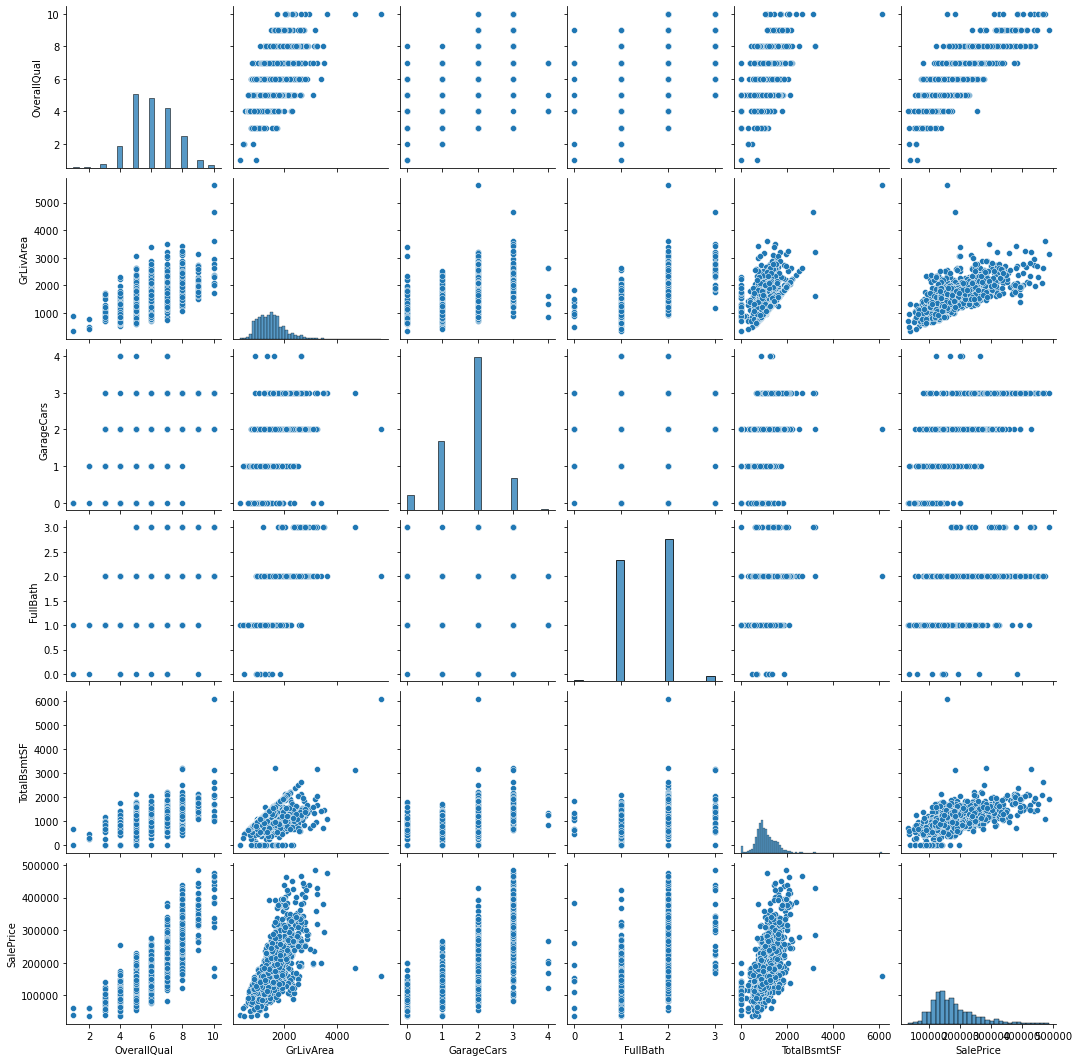

In [574]:
#EDA- Numeric Data - Top Features
data[num_top]
sns.pairplot(data[num_top])
plt.show()

The numeric features showed a linear correlation with the sale price(target variable), we can use the linear regression framework

Total numeric features 32


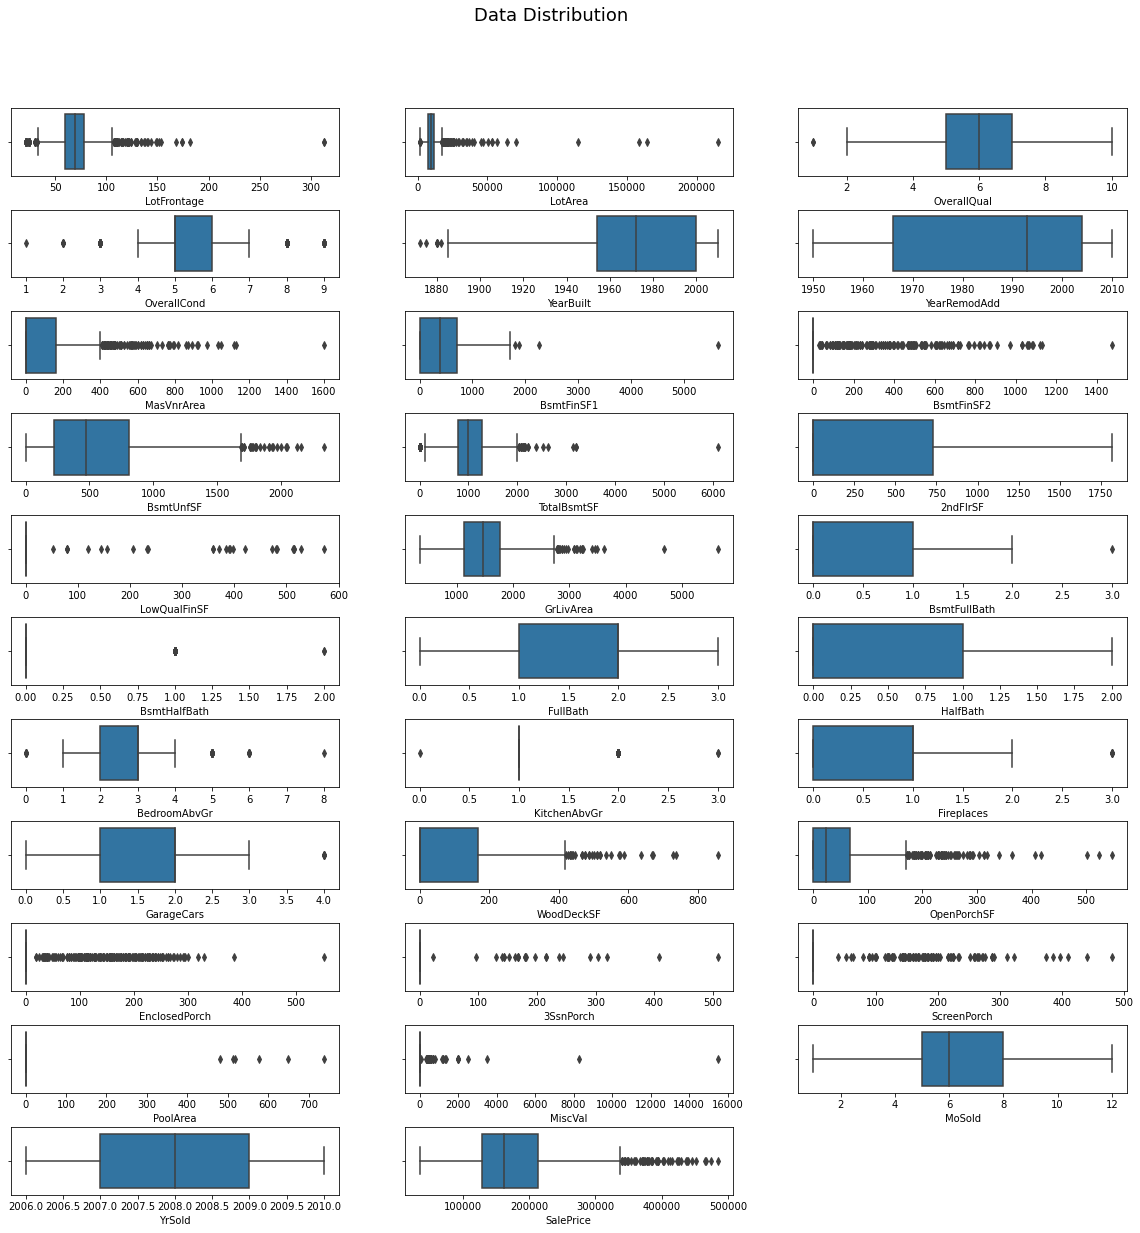

In [575]:
#Box Plot for numeric features
for corrnum in corr_num_vars:
    num_cols.remove(corrnum)
print("Total numeric features",len(num_cols))
tickers = num_cols
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Data Distribution", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(11, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.boxplot(data=data,x=ticker)
    ax.set_ylabel("")
plt.show()


In [576]:
#Removing columns with improper distribution in box plots(lots of outliers and no Iqr)
#These columns have lot of values which are equal and doesn't help in prediction of sale price
impr_dist_cols=["BsmtHalfBath","MiscVal","PoolArea","KitchenAbvGr","EnclosedPorch","3SsnPorch"]
data.drop(columns=impr_dist_cols,inplace=True)
num_cols=list(set(num_cols)-set(impr_dist_cols))        

In [577]:
#Categorical Features
cat_cols=list(data.select_dtypes(include=['object']).columns)
print(cat_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition']


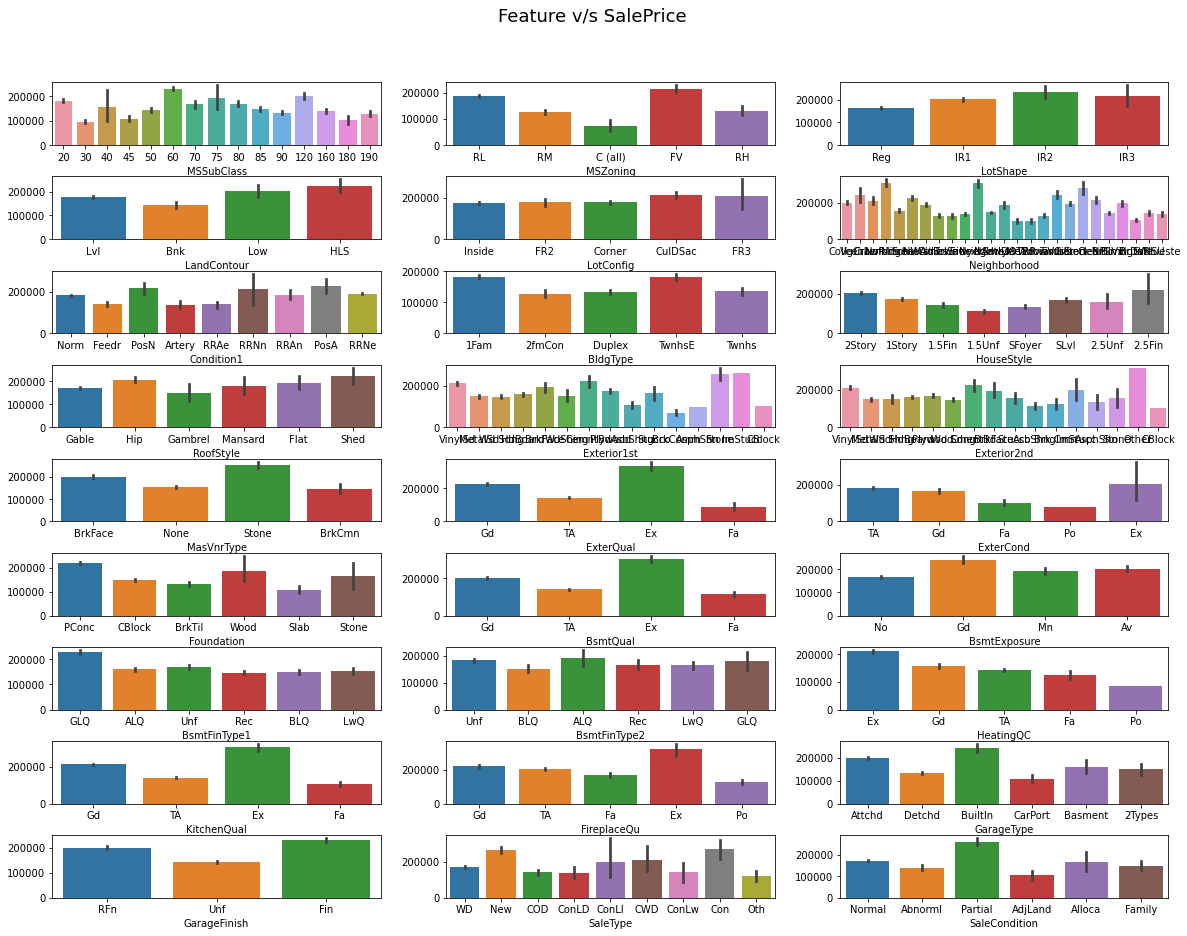

In [578]:
#Check Variation of categorical features with mean target variable

tickers = cat_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Feature v/s SalePrice", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(9, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.barplot(data=data,x=ticker,y="SalePrice")
    ax.set_ylabel("")


plt.show()

Categorical features seem to show a relation with the sale price

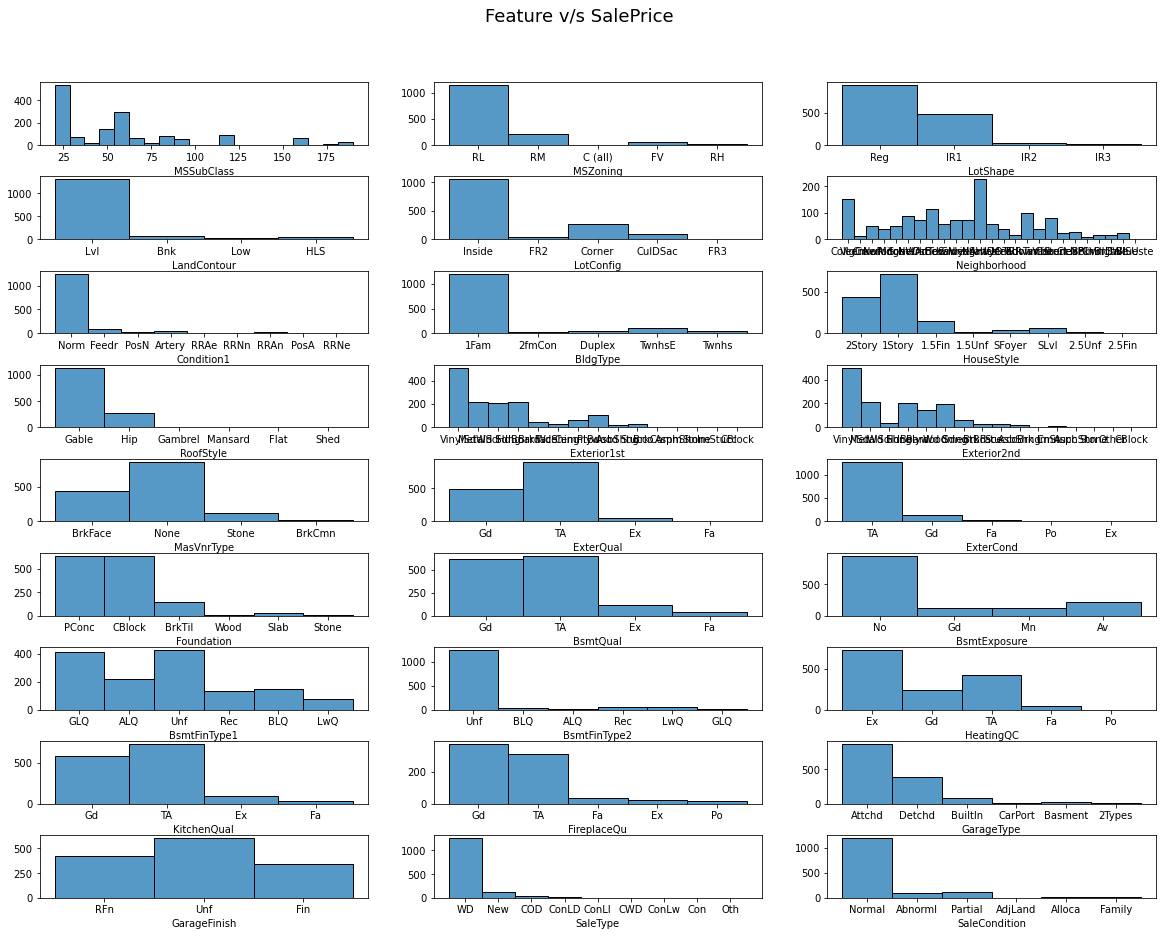

In [579]:
#Check Distribution of Categorical data

tickers = cat_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Feature v/s SalePrice", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(9, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.histplot(data[ticker])
    ax.set_ylabel("")

plt.show()

Some features show a correlation with the mean SalePrice and some variables have category imbalance such as SaleType,Condition1,SaleCondition,LotConfig

In [580]:
#EDA - Identifying Important variables based on data dictionary and distribution
top_cat=["MSZoning","GarageFinish","KitchenQual","ExterQual","BsmtQual"]

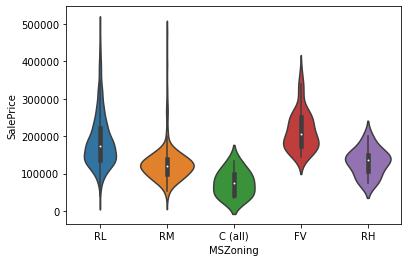

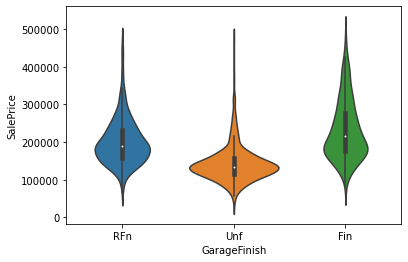

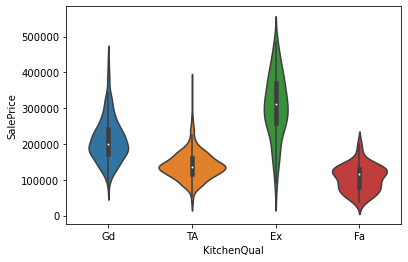

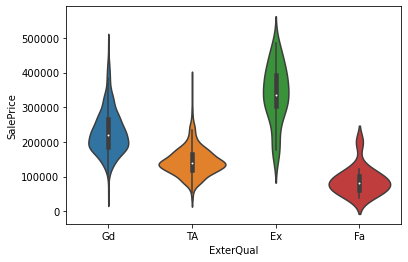

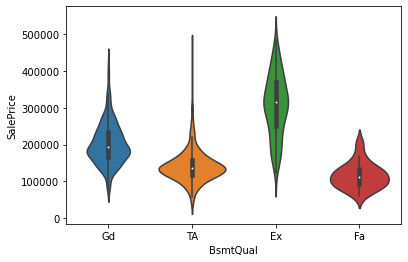

In [581]:
#Observing the data distribution of top categorical features with respect to the target variable
for tcat in top_cat:
    sns.violinplot(data=data,x=tcat,y="SalePrice")
    plt.show()

In [582]:
#Creation of Dummies for categorical variables
data=pd.get_dummies(data,drop_first=True)
print(data.shape)

(1451, 193)


In [583]:
#X & Y data
cols=list(data.columns)
y_col="SalePrice"
cols.remove(y_col)
X=data[cols]
y=data[y_col]

In [584]:
#Test-Train Split - 70-30% split
X_cols=list(data.columns)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
print("X train shape",X_train_orig.shape)
print("y train shape",y_train_orig.shape)
print("X test shape",X_test_orig.shape)
print("y test shape",y_test_orig.shape)

X train shape (1015, 192)
y train shape (1015,)
X test shape (436, 192)
y test shape (436,)


In [585]:
#Reshape ytrain and ytest to array
y_train=y_train_orig.values.reshape(-1,1)
y_test=y_test_orig.values.reshape(-1,1)

In [586]:
#Scaling Features
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_orig),columns=X_train_orig.columns)
X_test = pd.DataFrame(scaler.transform(X_test_orig),columns=X_train_orig.columns)

In [587]:
#RFE used for feature selection
lr = LinearRegression()
selector = RFE(lr, n_features_to_select=40, step=1)
selector = selector.fit(X_train, y_train)

In [588]:
#Preparing data with best features from RFE
best_features_rfe=list(X_train.columns[selector.support_])
print("The features selected by RFE are :",best_features_rfe)
X_train=X_train[best_features_rfe]
X_test=X_test[best_features_rfe]

The features selected by RFE are : ['LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'MSSubClass_120', 'MSSubClass_160', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_CemntBd', 'Exterior1st_VinylSd', 'Exterior2nd_CmentBd', 'Exterior2nd_VinylSd', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_TA', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_Gd', 'BsmtFinType1_Unf', 'BsmtFinType2_Unf', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'SaleType_New', 'SaleCondition_Partial']


In [589]:
#Function for linear regression for each set of features
def linear_regression_feature(X_tr,y_tr,vif_flag=1):
    features=list(X_tr.columns)
    #1. Train the model
    X_train_sm = sm.add_constant(X_tr[features])
    lr = sm.OLS(y_tr, X_train_sm).fit()
    print(lr.summary())

    #2. Checking multi-collinearity : VIF
    #If VIF flag is not zero, then only calculate VIF, by default it vif_flag=1
    if vif_flag!=0:
        # VIF
        vif = pd.DataFrame()
        features=X_tr[features]
        vif['Features'] = features.columns
        vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        print(vif)
    return lr

In [590]:
#Checking multicollinearity and significance of variables
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     173.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:44:38   Log-Likelihood:                -11744.
No. Observations:                1015   AIC:                         2.357e+04
Df Residuals:                     974   BIC:                         2.377e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

We can find multicollinearity and insignificant variables in the data for linear regression model

In [591]:
X_train.drop("SaleType_New",axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     173.6
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:44:38   Log-Likelihood:                -11755.
No. Observations:                1015   AIC:                         2.359e+04
Df Residuals:                     975   BIC:                         2.379e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

Exterior features might be correlated leading to high VIF, hence removing features leading to multi-collinearity and have high p-values also and based on understanding from data dictionary

In [592]:
X_train.drop(["Exterior1st_CemntBd","Exterior2nd_CmentBd","Exterior1st_VinylSd","Exterior2nd_VinylSd","ExterCond_Fa","ExterCond_TA","ExterCond_Gd"],axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     209.2
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:44:38   Log-Likelihood:                -11764.
No. Observations:                1015   AIC:                         2.359e+04
Df Residuals:                     982   BIC:                         2.376e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

In [593]:
#Roof Style variable has high VIF and p-values, hence removing them
X_train.drop(["RoofStyle_Hip","RoofStyle_Gable"],axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:44:38   Log-Likelihood:                -11768.
No. Observations:                1015   AIC:                         2.360e+04
Df Residuals:                     984   BIC:                         2.375e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

In [594]:
#Roof Style variable has high VIF and p-values, hence removing them
X_train.drop(["KitchenQual_TA","KitchenQual_Gd","KitchenQual_Fa"],axis=1,inplace=True)
lr=linear_regression_feature(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     232.6
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:44:39   Log-Likelihood:                -11794.
No. Observations:                1015   AIC:                         2.364e+04
Df Residuals:                     987   BIC:                         2.378e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.794e+

Model is now free from high multi-collinearity and all the features are also significant according to p-values

In [595]:
#Final data with selected features
final_cols=list(X_train.columns)
X_test=X_test[final_cols]
num_cols=len(final_cols)
print(f"After data preparation and feature selection, we are left with {num_cols} columns for advanced regression")

After data preparation and feature selection, we are left with 27 columns for advanced regression


In [596]:
#Function for Test & Train Metrics
def report_metrics(model,X_tst,y_tst,model_name):
    print(f"The best value of lambda(alpha) found in {model_name} Regression is :",list(model.best_params_.values())[0])
    r2_train_score=model.best_score_
    r2_test_score=metrics.r2_score(y_tst, model.predict(X_tst))
    test_mean_squared_score=metrics.mean_squared_error(y_tst, model.predict(X_tst))
    print("Train R2 score is :",round(r2_train_score,3))
    print("Test R2 score is  :",round(r2_test_score,3))
    print("Test RMSE score is  :",round(np.sqrt(test_mean_squared_score),3))

In [597]:
#Ridge Regression
parameters = {'alpha':list(range(0,1000,10))}
model = Ridge(random_state=42)
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)
Ridge_reg.fit(X_train,y_train)
report_metrics(Ridge_reg,X_test,y_test,"Ridge")

The best value of lambda(alpha) found in Ridge Regression is : 70
Train R2 score is : 0.833
Test R2 score is  : 0.852
Test RMSE score is  : 26546.233


In [598]:
#Lasso Regression
parameters = {'alpha':list(range(0,1000,10))}
model = Lasso(random_state=42)
Lasso_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)
Lasso_reg.fit(X_train,y_train)
report_metrics(Lasso_reg,X_test,y_test,"Lasso")

The best value of lambda(alpha) found in Lasso Regression is : 20
Train R2 score is : 0.83
Test R2 score is  : 0.848
Test RMSE score is  : 26844.843


#### Inferences :
-The optimal value of lambda for Ridge is 70 and for Lasso the optimal lambda is 20<br>
-We select Ridge as the best model, since it has marginally higher train and test R2 and marginally lower RMSE as compared to Lasso regularization<br>
-The Rsquare of the best model in training is 0.83 and in test is 0.85<br>
-The model is not overfitting because we are using regularization

In [599]:
ridge_coeff=pd.DataFrame(Ridge_reg.best_estimator_.coef_.transpose(), X_train.columns, columns=['Ridge Coefficients'])
lasso_coeff=pd.DataFrame(Lasso_reg.best_estimator_.coef_, X_train.columns, columns=['Lasso Coefficients'])
coeff_model=pd.concat([ridge_coeff,lasso_coeff],axis=1)
print("The coefficients of models in Ridge and Lasso regression are : \n",coeff_model.sort_values(by='Ridge Coefficients',ascending=False))

The coefficients of models in Ridge and Lasso regression are : 
                        Ridge Coefficients  Lasso Coefficients
OverallQual                  19599.272589        20240.197913
GrLivArea                    19270.209131        20775.752620
Neighborhood_NridgHt         10964.207817        11332.636587
YearBuilt                    10472.930324        11842.335634
GarageCars                    9989.723763         9468.910856
Neighborhood_NoRidge          6438.441131         6636.686317
OverallCond                   6184.145540         6928.743857
Fireplaces                    5801.249284         5343.716955
Neighborhood_Somerst          5717.987504         6243.521565
Neighborhood_Crawfor          5207.328559         5472.582906
Neighborhood_StoneBr          5119.107765         5495.375079
WoodDeckSF                    5031.588330         4869.574190
BsmtFullBath                  4533.485393         4526.911278
SaleCondition_Partial         4459.935649         3874.873961
LandC

#### Based on the coefficients of our model, we can infer the important variables as:
1. OverallQual
2. GrLivArea
3. Neighbourhood
4. YearBuilt   
5. GarageCars
6. MsSubClass        
7. BsmtQual         

In [600]:
#Ridge Regression - Based on Top 7 important features
best_features=["OverallQual","GrLivArea","Neighborhood_NridgHt","YearBuilt","GarageCars","MSSubClass_160","BsmtQual_Gd"]
parameters = {'alpha':list(range(0,1000,10))}
model_best7 = Ridge(random_state=42)
Ridge_reg_best7= GridSearchCV(model, parameters, scoring='r2',cv=5)
Ridge_reg_best7.fit(X_train[best_features],y_train)
print("Considering only top 7 features for the model:\n")
report_metrics(Ridge_reg_best7,X_test[best_features],y_test,"Ridge")

Considering only top 7 features for the model:

The best value of lambda(alpha) found in Ridge Regression is : 210
Train R2 score is : 0.77
Test R2 score is  : 0.802
Test RMSE score is  : 30711.461


Inference :The top 7 important features selected is able to explain about 77% in the train set and 80% variability on the test set

### Evaluating the model

In [601]:
#Prediction on test
y_pred_test=Ridge_reg.predict(X_test)

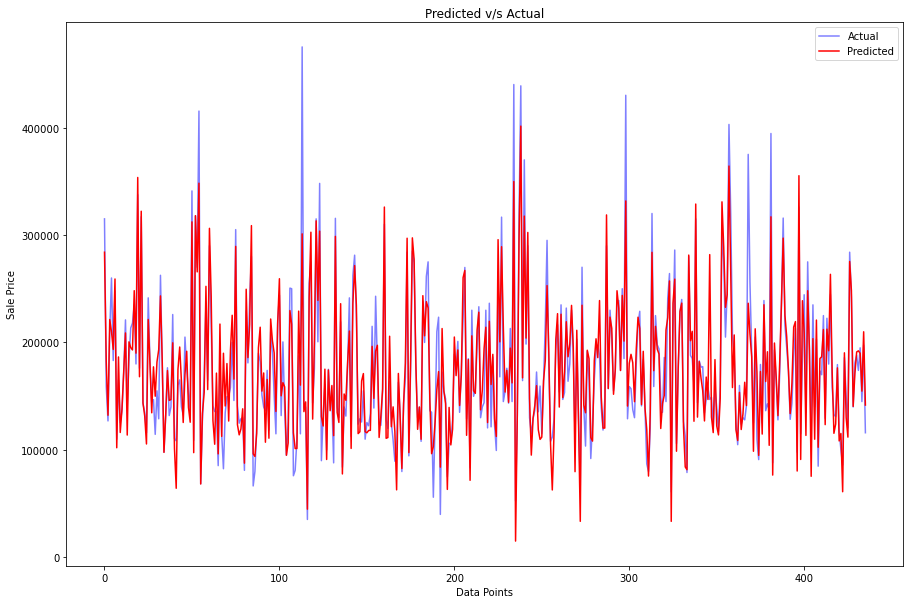

In [602]:
#Checking the predictions
x_vals=[i for i in range(len(y_test))]
plt.figure(figsize=(15,10))
plt.plot(x_vals,y_test,color='blue',label="Actual",alpha=0.5)
plt.plot(x_vals,y_pred_test,color='red',label="Predicted")
plt.legend()
plt.xlabel("Data Points")
plt.ylabel("Sale Price")
plt.title("Predicted v/s Actual")
plt.show()

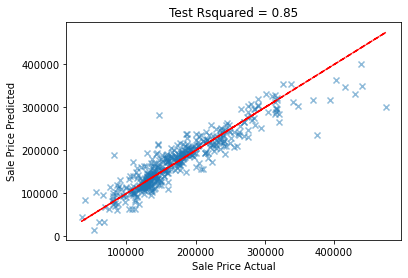

In [603]:
#Goodness of fit
plt.scatter(y_test, y_pred_test,marker='x',alpha=0.5)
plt.plot(y_test, y_test,color="r",linestyle="--")
plt.ylabel("Sale Price Predicted")
plt.xlabel("Sale Price Actual")
plt.title(f"Test Rsquared = 0.85")
plt.show()

Model Inference :<br>For high values of Sales Price(>300000), the model is not able to predict, but on a general trend of SalesPrice, the model is able to predict the data actual points

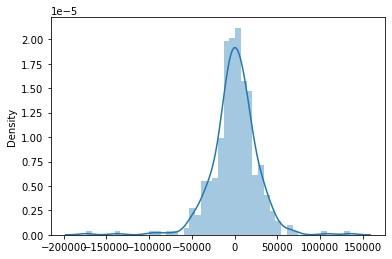

In [604]:
#Residual Distribution
res=y_pred_test-y_test
sns.distplot(res)
plt.show()

In [605]:
#Residuals are normally distributed with a mean of 0

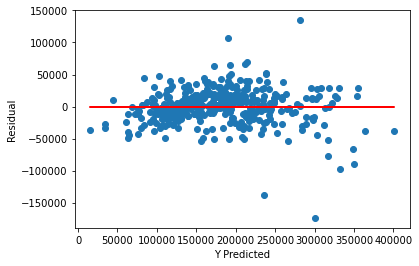

In [606]:
#Y Pred v.s Residuals
plt.scatter(y_pred_test,res)
plt.plot(y_pred_test,[0]*len(y_pred_test),color='red')
plt.xlabel("Y Predicted")
plt.ylabel("Residual")
plt.show()

The residuals has a higher variance when the sale price is above 300000

Overall,the assumptions of linear regression are satisfied, residuals follow a normal distribution and the model can be used to predict the house prices in Australia

#### Conclusions -
I. Data was cleaned and prepared, features were selected through RFE by coarse tuning and through VIF and p-values by fine tuning<br>
II. Optimal value of lambda for lasso is 20 and for ridge it is 70<br>
III. Advanced Regression : Ridge regression seemed to perform better than lasso with a train R-square of 0.83 & test R-square value of 0.85<br> 
IV. The important variables for the prediction of sales price of houses are:<br>
1. OverallQual
2. GrLivArea
3. Neighbourhood
4. YearBuilt   
5. GarageCars
6. MsSubClass        
7. BsmtQual         

# End of Assignment Part I

### Assignment Part II : Subjective Questions

Question 1

- What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

Code 1

In [608]:
#Ridge Regression - Double Alpha
parameters = {'alpha':[140]}
model = Ridge(random_state=42)
Ridge_reg_2l= GridSearchCV(model,parameters,scoring='r2',cv=5)
Ridge_reg_2l.fit(X_train,y_train)
report_metrics(Ridge_reg_2l,X_test,y_test,"Ridge(double lambda)")

The best value of lambda(alpha) found in Ridge(double lambda) Regression is : 140
Train R2 score is : 0.832
Test R2 score is  : 0.852
Test RMSE score is  : 26545.351


In [609]:
#Lasso Regression
parameters = {'alpha':[40]}
model = Lasso(random_state=42)
Lasso_reg_2l= GridSearchCV(model, parameters, scoring='r2',cv=5)
Lasso_reg_2l.fit(X_train,y_train)
report_metrics(Lasso_reg_2l,X_test,y_test,"Lasso(double lambda)")

The best value of lambda(alpha) found in Lasso(double lambda) Regression is : 40
Train R2 score is : 0.83
Test R2 score is  : 0.849
Test RMSE score is  : 26811.271


In [610]:
#Show coefficients after doubling lambda
ridge_coeff=pd.DataFrame(Ridge_reg.best_estimator_.coef_.transpose(), X_train.columns, columns=['Ridge Coefficients'])
ridge_coeff_2l=pd.DataFrame(Ridge_reg_2l.best_estimator_.coef_.transpose(), X_train.columns, columns=['Ridge(2l) Coefficients'])
lasso_coeff=pd.DataFrame(Lasso_reg.best_estimator_.coef_, X_train.columns, columns=['Lasso Coefficients'])
lasso_coeff_2l=pd.DataFrame(Lasso_reg_2l.best_estimator_.coef_, X_train.columns, columns=['Lasso(2l) Coefficients'])
coeff_model_2l=pd.concat([ridge_coeff,ridge_coeff_2l,lasso_coeff,lasso_coeff_2l],axis=1)
coeff_sort_round_2l=coeff_model_2l.sort_values(by='Ridge Coefficients',ascending=False).round(1)
# print("The coefficients of models in Ridge and Lasso regression after doubling lambda are : \n")
coeff_sort_round_2l

,Ridge Coefficients,Ridge(2l) Coefficients,Lasso Coefficients,Lasso(2l) Coefficients
OverallQual,19599.3,18905.1,20240.2,20279.4
GrLivArea,19270.2,18169.8,20775.8,20744.9
Neighborhood_NridgHt,10964.2,10556.9,11332.6,11313.2
YearBuilt,10472.9,9643.5,11842.3,11818.0
GarageCars,9989.7,10220.7,9468.9,9475.9
Neighborhood_NoRidge,6438.4,6231.3,6636.7,6614.2
OverallCond,6184.1,5601.0,6928.7,6893.5
Fireplaces,5801.2,6123.8,5343.7,5335.8
Neighborhood_Somerst,5718.0,5275.2,6243.5,6208.1
Neighborhood_Crawfor,5207.3,4962.8,5472.6,5456.0


Answer 1

- The optimal value of alpha for ridge regression is 70 and for lasso regression it's 20<br>
- We observe that there is very minimal change in the train & test R-square for both ridge and lasso regression after lambda is doubled. The R-square value reduces marginally and the RMSE increases marginally for our model after doubling lambda. For Ridge regression, the coefficients remains almost the same whereas in Lasso regression, there are some minor changes to the coefficients.
- The important predictor variables still remain the same for Lasso & Ridge regression, even after doubling lambda

Question 2

- You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

Answer 2
- We will choose an which model to apply based on the overall accuracy of the model, how good it is able to explain the variablity of the target variable
- We will make a decision between Ridge and Lasso based on observing the test and train R-squared values.
- We select the model which does not have much difference between train and test metrics, and also based on which of these models have a lower RMSE values.

Question 3

- After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

Code 3

In [611]:
#Lasso Regression - Dropping important 5 predictors
best_features=["OverallQual","GrLivArea","Neighborhood_NridgHt","YearBuilt","GarageCars"]
#Drop 5 important features from model
X_train_di5=X_train.drop(columns=best_features,axis=1)
X_test_di5=X_test.drop(columns=best_features,axis=1)
#Model Build
parameters = {'alpha':list(range(0,1000,10))}
model_dropimp5 = Lasso(random_state=42)
Lasso_dropimp5= GridSearchCV(model, parameters, scoring='r2',cv=5)
Lasso_dropimp5.fit(X_train_di5,y_train)
print("After removing the top 5 features for the model:\n")
report_metrics(Lasso_dropimp5,X_test_di5,y_test,"Lasso(Drop 5 imp var)")
coeff_di5=pd.DataFrame(Lasso_dropimp5.best_estimator_.coef_,X_train_di5.columns, columns=['Lasso Coefficients'])
coeff_di5.sort_values(by="Lasso Coefficients",ascending=False)

After removing the top 5 features for the model:

The best value of lambda(alpha) found in Lasso(Drop 5 imp var) Regression is : 0
Train R2 score is : 0.598
Test R2 score is  : 0.605
Test RMSE score is  : 43351.023


,Lasso Coefficients
Fireplaces,20176.752558
SaleCondition_Partial,14134.974442
Neighborhood_NoRidge,12615.463885
WoodDeckSF,11115.752295
BsmtFinType2_Unf,9735.356320
LandContour_Lvl,8548.314770
LotFrontage,8390.803000
Neighborhood_Somerst,8373.985012
Neighborhood_StoneBr,7834.632920
BsmtFullBath,6866.563250


Answer 3
- After dropping the top 5 important variables, we could observe that in Lasso regression, the train & test R-square reduces from 0.8 to 0.6
- Also the RMSE values shoots up slightly
- The five important predictor variables now are : 
1. BsmntQual
2. FirePlaces
3. SaleCondition
4. WoodDeckSF
5. BsmtFinType2	


Question 4<br>
- How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?


Answer 4<br>
- We can make sure our model is robust and generalisable, based on the train & test R-square values for the model. There should be not a high difference between the R-square values of train and test data. If the model has high train R-square and low test R-square means that it is memorizing the data,and not able to understand the trends and generalize, changes to input will have significant impacts to the output. It has high variance and it is not robust.
-  To make sure, there is no overfitting, we can use regularization but we have to choose an optimal value of lambda which can reduce the variance but this will result in decreasing the accuracy of the model because it makes the model less complex leading to reduction in variance and increase in bias. But this bias-variance tradeoff helps us to make the model generalisable and robust

## End of Notebook